# Effect of Funding Distribution on Public School Success
#### Collaborators: Violet Dong (xdong1), Tara Jawahar  (tjawahar), Sohan Kalva (skalva)
## Introduction

The following map shows the distribution of public high school graduation rates across the US. The graduation rates range from low 60% to high 90%, indicating a rather uneven level of education across the country. The goal of our project is to investigate the possible reasons for this discrepancy, specifially the effect of funding distribution on public school success. 

<img src="files/grad_map.png" width="400" height="400">


## Data Collection and Manipulation

To measure the success of public schools, we considered five major matrics, high school graduation rates, SAT scores, National Assessment of Educational Progress (NAEP), college acceptance rates and attendance. However, we were only able to find substantial data on high school graduation rates and NAEP from The Nation's Report Card and National Center for Education Statistics. The finance data was obtained from census.gov. We mainly focused on two levels of govermental bodies based on the data available, county and state.

Because the information needed was spread across various data sets, our approach was to clean each data set first to extract the data we needed to standard format and then join two tables on county or state to combine the predictive variables (finance data) and the response variables(graduation rate, test scores etc) into one table. 

We used Pandas to load and manipulate the data, matplotlib to visualize the data, and scikit learn and scipy to select key features as well as generate linear regrssion models. 


In [5]:
#Load Packages 
import xlrd
import pandas as pd
import csv
import sqlite3
import matplotlib
#matplotlib.use("svg")
import matplotlib.pyplot as plt
import os
if not os.environ.get("DISABLE_TESTING", False):
    %matplotlib inline
plt.style.use('ggplot')
import numpy as np
import re
from sklearn import linear_model
import statsmodels.api as sm
from scipy import stats
from random import sample
import math
import random

UsageError: Invalid GUI request 'svg', valid ones are:dict_keys(['inline', 'nbagg', 'notebook', 'ipympl', 'widget', None, 'qt4', 'qt', 'qt5', 'wx', 'tk', 'gtk', 'gtk3', 'osx', 'asyncio'])


## Data Analysis

The specific finance information we used in this project was per pupil amounts for current spending of the 100 largest public elementary-secondary school systems, percentage distribution of revenue, expenditure, and total revenue. The following code chunks transform each excel sheet into a Pandas DataFrame.

In [15]:
#Load the finance data
fin_df = pd.read_excel("financial_data.xls", sheet_name=["14","15","16","17","18"], skiprow=5)
#load grad_rate_total.csv using pandas
grad_rate = pd.read_csv("graduation_rates_total.csv",encoding='latin-1')

In [16]:
fin_df_pps = fin_df["18"].fillna(-1)
per_pupil_spending = pd.DataFrame([], columns=["Rank", "School System", "State", "Enrollment", "Instruction_Total", 
                              "Instruction_Salaries", "Instruction_EmployeeBenefits", "Support_Total", 
                              "Support_Pupil", "Support_Staff","Support_GeneralAdmin", "Support_SchoolAdmin"])
per_pupil_spending["Rank"] = [i for i in range(100)]
per_pupil_spending["School System"] = [i for i in fin_df_pps["Unnamed: 2"][4:] if i !="School System" and i != -1]
per_pupil_spending["State"] = [i for i in fin_df_pps["Unnamed: 3"][4:] if i !="State" and i != -1]
per_pupil_spending["Enrollment"] = [int(i) for i in fin_df_pps["Unnamed: 4"] if i != -1 and type(i) != str]
per_pupil_spending["Instruction_Total"] = [int(i) for i in fin_df_pps["Unnamed: 8"] if i != -1 and type(i) != str]
per_pupil_spending["Instruction_Salaries"] = [int(i) for i in fin_df_pps["Unnamed: 9"] if i != -1 and type(i) != str]
per_pupil_spending["Instruction_EmployeeBenefits"] = [int(i) for i in fin_df_pps["Unnamed: 10"] if i != -1 and type(i) != str]
per_pupil_spending["Support_Total"] = [int(i) for i in fin_df_pps["Unnamed: 11"] if i != -1 and type(i) != str]
per_pupil_spending["Support_Pupil"] = [int(i) for i in fin_df_pps["Unnamed: 12"] if i != -1 and type(i) != str]
per_pupil_spending["Support_Staff"] = [int(i) for i in fin_df_pps["Unnamed: 13"] if i != -1 and type(i) != str]
per_pupil_spending["Support_GeneralAdmin"] = [int(i) for i in fin_df_pps["Unnamed: 14"] if i != -1 and type(i) != str]
per_pupil_spending["Support_SchoolAdmin"] = [int(i) for i in fin_df_pps["Unnamed: 15"] if i != -1 and type(i) != str]

#per_pupil_spending.to_csv(index=False)

In [17]:
#Finance sheet 17
fin_df_percent_dist_rev = fin_df["17"].fillna(-1)

In [18]:
percent_dist_rev = pd.DataFrame([], columns=["Rank","School System","State","Enrollment","Overall Total Percentage",
                                             "Federal Total Percentage","Federal Title I","State Total Percentage",
                                             "State General Formula Assistance","Local Total Percentage",
                                             "Local Taxes Parent Government Contributions","Other Local Government",
                                            "Charges"])

percent_dist_rev["Rank"] = [i for i in range(100)]
percent_dist_rev["School System"] = [i for i in fin_df_percent_dist_rev["Unnamed: 2"][4:] if i !="School System" and i != -1]
percent_dist_rev["State"] = [i for i in fin_df_percent_dist_rev["Unnamed: 3"][4:] if i !="State" and i != -1]
percent_dist_rev["Enrollment"] = [int(i) for i in fin_df_percent_dist_rev["Unnamed: 4"] if i != -1 and type(i) != str]
percent_dist_rev["Overall Total Percentage"] = [float(i) for i in fin_df_percent_dist_rev["Unnamed: 5"][4:] if i !="Total" and i != -1]
percent_dist_rev["Federal Total Percentage"] = [float(i) for i in (fin_df_percent_dist_rev["Unnamed: 6"]) if i !="Federal sources" and i != "Total2" and i != -1]
percent_dist_rev["Federal Title I"] = [float(i) for i in (fin_df_percent_dist_rev["Unnamed: 7"]) if i !="Federal sources" and i != "Title I" and i != -1]
percent_dist_rev["State Total Percentage"] = [float(i) for i in (fin_df_percent_dist_rev["Unnamed: 8"]) if i !="State sources" and i != "Total2" and i != -1]
percent_dist_rev["State General Formula Assistance"] = [float(i) for i in (fin_df_percent_dist_rev["Unnamed: 9"]) if i !="State sources" and i != "General" and i !="formula" and i != "assistance" and i != -1]
percent_dist_rev["Local Total Percentage"] = [float(i) for i in (fin_df_percent_dist_rev["Unnamed: 10"]) if i !="Local sources" and i != "Total2" and i != -1]

#This function changes the (Z) to zeros  
def changeZ(i):
    try:
        return (float(i))
    except:
        return(0.0)

percent_dist_rev["Local Taxes Parent Government Contributions"] = [changeZ(i) for i in (fin_df_percent_dist_rev["Unnamed: 11"]) if i !="Local sources" and i != -1 and i!="Taxes and" and i != "parent" and i != "government" and i != "contributions"]
percent_dist_rev["Other Local Government"] = [changeZ(i) for i in (fin_df_percent_dist_rev["Unnamed: 12"]) if i !="Local sources" and i != -1 and i!="Other" and i != "local" and i != "governments"]
percent_dist_rev["Charges"] = [changeZ(i) for i in (fin_df_percent_dist_rev["Unnamed: 13"]) if i !="Local sources" and i != -1 and i!="Charges"]


percent_dist_rev.to_csv("percent_dist_rev.csv",index=False)

In [19]:
#Finance sheet 16
fin_df_expenditure = fin_df["16"].fillna(-1)

In [20]:
#Finance Sheet 16
expenditure = pd.DataFrame([], columns=["Rank","School System","State","Enrollment",
                                       "Elementary_secondary Expenditure Total", "Selected Objects Salaries",
                                       "Selected Objects Employee Benfits","Instruction Salaries","Instruction Employee Benefits",
                                       "Support Services Pupil Support","Support Services Instructive Staff Support",
                                       "Support Services General Administration","Support Services School Administration",
                                       "Support Services Other and Nonspecified","Other Current Spending","Capital Outlay",
                                       "Inter-governmental","Interest On Debt"])

expenditure["Rank"] = [i for i in range(100)]
expenditure["School System"] = percent_dist_rev["School System"]
expenditure["State"] = percent_dist_rev["State"]
expenditure["Enrollment"] = percent_dist_rev["Enrollment"]
expenditure["Elementary_secondary Expenditure Total"] = [int(i) for i in fin_df_expenditure["Unnamed: 5"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="Total" and i != -1 and i != "Elementary-secondary expenditure"]
expenditure["Selected Objects Salaries"] = [int(i) for i in fin_df_expenditure["Unnamed: 7"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="For selected objects" and i != -1 and i != "Salaries and" and i != "wages"]
expenditure["Selected Objects Employee Benfits"] = [int(i) for i in fin_df_expenditure["Unnamed: 8"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i != -1 and i != "Employee" and i != "benefits"]
expenditure["Instruction Salaries"] = [int(i) for i in fin_df_expenditure["Unnamed: 10"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i != -1 and i != "Salaries and" and i != "wages"]
expenditure["Instruction Employee Benefits"] = [int(i) for i in fin_df_expenditure["Unnamed: 11"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i != -1 and i != "Employee" and i != "benefits"]
expenditure["Support Services Pupil Support"] = [int(i) for i in fin_df_expenditure["Unnamed: 5"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "Pupil" and i != "support"]
expenditure["Support Services Instructive Staff Support"] = [int(i) for i in fin_df_expenditure["Unnamed: 6"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "Instructional" and i != "staff" and i != "support"]
expenditure["Support Services General Administration"] = [int(i) for i in fin_df_expenditure["Unnamed: 7"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "General" and i != "adminis-" and i != "tration"]
expenditure["Support Services School Administration"] = [int(i) for i in fin_df_expenditure["Unnamed: 8"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "School" and i != "adminis-" and i != "tration"]
expenditure["Support Services Other and Nonspecified"] = [int(i) for i in fin_df_expenditure["Unnamed: 9"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "Other and" and i != "nonspecified"]
expenditure["Other Current Spending"] = [int(i) for i in fin_df_expenditure["Unnamed: 10"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "Other" and i != "current" and i != "spending"]
expenditure["Capital Outlay"] = [int(i) for i in fin_df_expenditure["Unnamed: 11"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "Capital" and i != "outlay"]
expenditure["Inter-governmental"] = [int(i) for i in fin_df_expenditure["Unnamed: 12"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "Inter-" and i != "governmental"]
expenditure["Interest On Debt"] = [int(i) for i in fin_df_expenditure["Unnamed: 13"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i != -1 and i != "Interest" and i != "on debt"]



expenditure.to_csv("expenditure.csv",index=False)

In [21]:
#only take the grad rate of the most recent year 
#generate a new data frame
new_frame = []
grad_rate_sort_year = grad_rate.sort_values(by='year',ascending=False)
grad_rate_sort_year_sorted = grad_rate_sort_year.groupby(["name"])
for g in grad_rate_sort_year_sorted:
    new_frame.append(g[1].iloc[0,:])


reduced_grad_rate = pd.DataFrame(new_frame)
#new grad rate data frame with the most recent grad rate
reduced_grad_rate = reduced_grad_rate.reset_index().drop(["index"],axis=1)


#collect the counties and states separately in the grad rate data 
#for matching purposes
county = []
state = []

for name in reduced_grad_rate["name"]:
    county_name, state_name = name.split(", ")
    county.append(county_name)
    state.append(state_name)
    
#change all the county name to ones without the trailing "county"
tmp = []
for i in range(len(county)):
        c = county[i]
        k = [j for j in c.split(" County") if j != ""]
        tmp = tmp+k
        
county = tmp

After loading the finance data and the graduation rate data, the next step is to join two tables on common counties and states. The following code shows the process. However, out of the 100 most populous counties we collected from the census website, only 98 were found on the graduation rate data set. Therefore, the first part of the linear regression analysis was done with 98 counties.

In [22]:
school_system = per_pupil_spending["School System"]

#list of indices for the per_pupil_spending data frame 
#names can be found in grad rate data
school_final_ind = []

#indices of the grad rate data that match up the per pupil spending
grad_rate_ind = []

#graduation rate in order of the per pupil spending data frame
grad_rate_values = []

for i in range(len(per_pupil_spending)):
    school = school_system[i]
    for j in range(len(county)):
        c = county[j]
        s = state[j]
        if (c.lower().replace("'","") in school.lower().replace("'","") and s==per_pupil_spending["State"][i]):
            school_final_ind.append(i)
            grad_rate_ind.append(j)
            grad_rate_values.append(reduced_grad_rate["value"][j])
            
per_pupil_spending_with_grad = per_pupil_spending.loc[school_final_ind,:]
per_pupil_spending_with_grad["grad_rate"] = grad_rate_values 

per_pupil_spending_with_grad.to_csv("per_pupil_spending_with_grad.csv",index=False)

#per_pupil_spending_with_grad.reset_index().drop(["index"],axis=1)


In [23]:
fin_df_tot_rev = fin_df["15"].fillna(-1)
#Revenue of the 100 Largest .....
#Finance page 15
tot_rev = pd.DataFrame([], columns=["Rank","School System","State","Enrollment",
                                   "Total Revenue","Federal Total","Federal Titile I","Federal Special Education",
                                   "Federal Child Nutrition","Federal Other and Nonspecified","State Total","State General Formula Assistance",
                                   "State Special Education","State Transportation","State Other and Nonspecified","Local Total",
                                   "Local Total Taxes","Local Property Taxes","Local Parent Government Contribution","Local From Cities and Counties",
                                   "Local From Other School Systems"])

def changeInt(i):
    try:
        return (int(i))
    except:
        return(0)

tot_rev["Rank"] = [i for i in range(100)]
tot_rev["School System"] = percent_dist_rev["School System"]
tot_rev["State"] = percent_dist_rev["State"]
tot_rev["Enrollment"] = percent_dist_rev["Enrollment"]
tot_rev["Total Revenue"] = [int(i) for i in fin_df_tot_rev["Unnamed: 5"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="Total" and i != -1 and i != "Elementary-secondary revenue"]
tot_rev["Federal Total"] = [int(i) for i in fin_df_tot_rev["Unnamed: 6"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="Total" and i != -1 and i != "Federal sources"]
tot_rev["Federal Titile I"] = [int(i) for i in fin_df_tot_rev["Unnamed: 7"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="Title I" and i != -1 ]
tot_rev["Federal Special Education"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 8"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="Special" and i != -1 and i != "education"]/tot_rev["Enrollment"]
tot_rev["Federal Child Nutrition"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 9"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="Child" and i != -1 and i != "nutrition"]/tot_rev["Enrollment"]
tot_rev["Federal Other and Nonspecified"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 10"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="Child" and i != -1 and i != "Other and" and i != "nonspecified"]
tot_rev["State Total"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 11"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="State sources" and i != -1 and i != "Total"]
tot_rev["State General Formula Assistance"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 12"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="General" and i != -1 and i != "formula" and i != "assistance"]
tot_rev["State Special Education"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 13"][np.concatenate((np.arange(4,74,1),np.arange(149,217,1)))] if i !="Special" and i != -1 and i != "education"]/tot_rev["Enrollment"]
tot_rev["State Transportation"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 4"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i !="State sources--Con." and i != -1 and i != "Transpor-" and i != "tation" and i !="Elementary-secondary revenue--Con."]/tot_rev["Enrollment"]
tot_rev["State Other and Nonspecified"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 5"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i !="Other and" and i != -1 and i != "nonspecified"]
tot_rev["Local Total"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 6"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i !="Local sources" and i != -1 and i != "Total"]
tot_rev["Local Total Taxes"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 7"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i !="Total taxes" and i != -1]
tot_rev["Local Property Taxes"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 8"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i !="Property" and i != -1 and i != "taxes"]/tot_rev["Enrollment"]
tot_rev["Local Parent Government Contribution"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 9"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i !="Parent" and i != -1 and i != "government" and i != "contributions"]
tot_rev["Local From Cities and Counties"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 10"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i !="From cities" and i != -1 and i != "and" and i != "counties"]
tot_rev["Local From Other School Systems"] = [changeInt(i) for i in fin_df_tot_rev["Unnamed: 11"][np.concatenate((np.arange(76,145,1),np.arange(220,288,1)))] if i !="From other" and i != -1 and i != "systems" and i != "school"]

tot_rev_with_grad = tot_rev.loc[school_final_ind,:]
tot_rev_with_grad["grad_rate"] = grad_rate_values


tot_rev_with_grad.to_csv("tot_rev_with_grad.csv",index=False)


In [24]:
expenditure_with_grad = expenditure.loc[school_final_ind,:]
expenditure_with_grad ["grad_rate"] = grad_rate_values
expenditure_with_grad.to_csv("expenditure_with_grad.csv",index=False)

percent_dist_rev_with_grad = percent_dist_rev.loc[school_final_ind,:]
percent_dist_rev_with_grad["grad_rate"] = grad_rate_values
percent_dist_rev_with_grad.to_csv("percent_dist_rev_with_grad.csv",index=False)

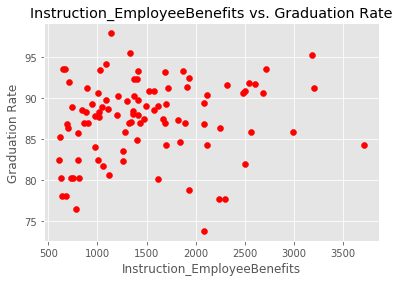

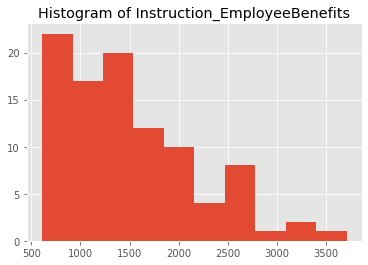

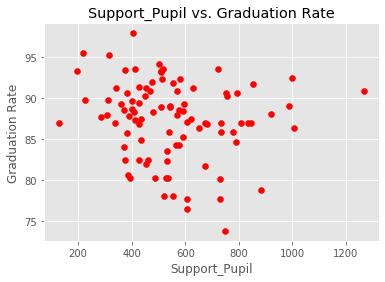

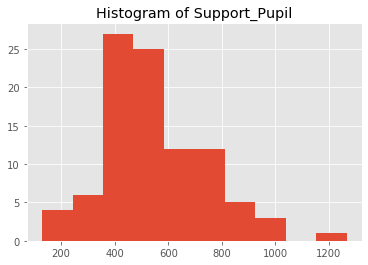

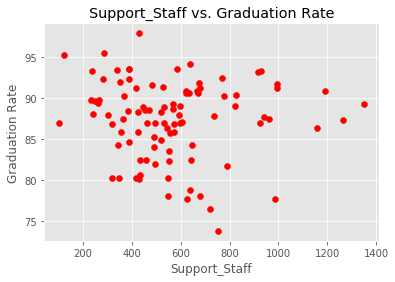

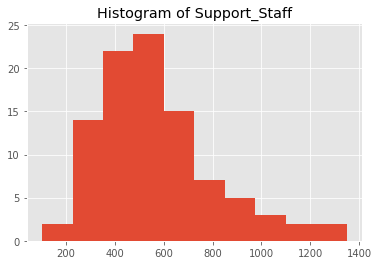

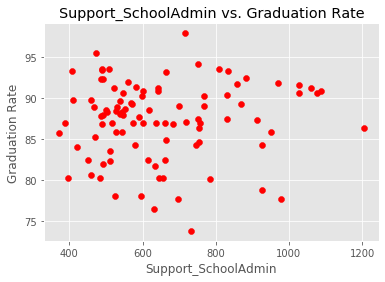

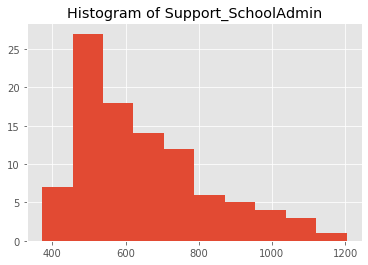

In [25]:
#Remove outliers and then plot

def outliers_rem(features,df):
    features_dict = {}
    for feature in features:
        description = df[feature].describe()
        feature_mean = description["mean"]
        feature_std_3 = description["std"]*3
        features_dict[feature] = (feature_mean + feature_std_3,feature_mean - feature_std_3)
    return features_dict

def EDA(features_dict, df,log = False):
    for feature in features_dict:
        tmp = df[df[feature]<=features_dict[feature][0]]
        tmp = tmp[tmp[feature]>=features_dict[feature][1]]
        if log:
            plt.scatter(np.log(tmp[feature]),np.log(tmp["grad_rate"]),color="red")
            plt.xlabel(feature + " in log scale")
        else:
            plt.scatter(tmp[feature],tmp["grad_rate"],color="red")
            plt.xlabel(feature)
        plt.ylabel("Graduation Rate")
        plt.title(feature+" vs. Graduation Rate")
        plt.show()
        
        plt.hist(tmp[feature])
        plt.title("Histogram of "+feature)
        plt.show()
    
    
    

features = ["Instruction_EmployeeBenefits","Support_Pupil","Support_Staff","Support_SchoolAdmin"]

a = outliers_rem(features,per_pupil_spending_with_grad)

EDA(a,per_pupil_spending_with_grad)
    

As shown in the figures above, the histograms of employee benefits, pupil support, staff support and school administration are right skewed, with most schools commiting less than $800 per pupil. However, there is a small amount of schools reach extraordinarily high amount of spending per pupil. At first glance, there does not appear to be a linear relationship between graduation rate and employee benefits or with school administration. Though not obvious, graduation rate appear to have a linear relationship with pupil suppurt and staff support, which intuitively makes sense. We then ran a multiple linear regression on these four features and high school graduation to identify the features that are most correlated with the graduation rate. 

In [26]:
random.seed(9001)
inds = range(0,len(per_pupil_spending_with_grad))
rand_ind = sample(inds,len(inds))
train_ind = rand_ind[0:math.floor(len(inds)*0.8):1]
test_ind = rand_ind[math.floor(len(inds)*0.8)::1]

per_pupil_train = per_pupil_spending_with_grad.reset_index().drop(["index"],axis=1).iloc[train_ind,:]
                                                              
per_pupil_train_resp = per_pupil_train["grad_rate"]
per_pupil_train_predictors = per_pupil_train[["Instruction_EmployeeBenefits","Support_Pupil","Support_Staff","Support_SchoolAdmin"]]


results_per_pupil = sm.OLS(per_pupil_train_resp, per_pupil_train_predictors).fit()

print(results_per_pupil.summary())

                                 OLS Regression Results                                
Dep. Variable:              grad_rate   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              208.9
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    1.69e-39
Time:                        21:47:46   Log-Likelihood:                         -361.45
No. Observations:                  78   AIC:                                      730.9
Df Residuals:                      74   BIC:                                      740.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

The linear regression summary table above shows through p-values that pupil support and school administration are the most important features out of the four features. The multiple linear regression model run only these two features are shown below. AIC using two features is slightly than using four features.

                                 OLS Regression Results                                
Dep. Variable:              grad_rate   R-squared (uncentered):                   0.918
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              425.9
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    5.11e-42
Time:                        21:59:21   Log-Likelihood:                         -361.72
No. Observations:                  78   AIC:                                      727.4
Df Residuals:                      76   BIC:                                      732.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

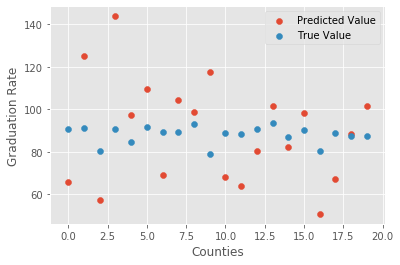

In [35]:
per_pupil_train_predictors_mod = per_pupil_train[["Support_Pupil","Support_SchoolAdmin"]]
results_per_pupil_mod = sm.OLS(per_pupil_train_resp, per_pupil_train_predictors_mod).fit()

print(results_per_pupil_mod.summary())


per_pupil_test = per_pupil_spending_with_grad.reset_index().drop(["index"],axis=1).iloc[test_ind,:]
k = results_per_pupil_mod.predict(per_pupil_test[["Support_Pupil","Support_SchoolAdmin"]])

plt.scatter(range(int(0),int(len(k))),k)
plt.scatter(range(int(0),int(len(k))),per_pupil_test["grad_rate"])
plt.legend(["Predicted Value","True Value"])
plt.xlabel("Counties")
plt.ylabel("Graduation Rate")
plt.show()

The scatter plot above displays the true values and their corresponding predicted values. Considering the samll range of graduation rate distribution, the predicted values are extremely inaccurate. 

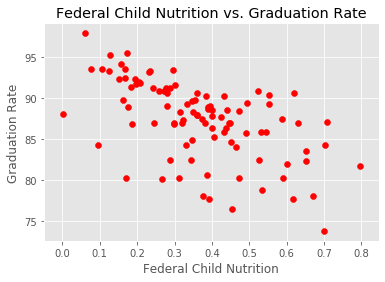

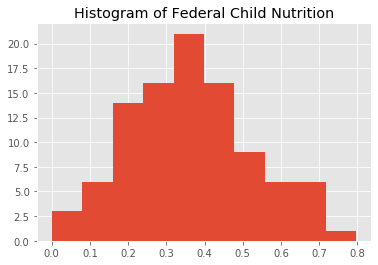

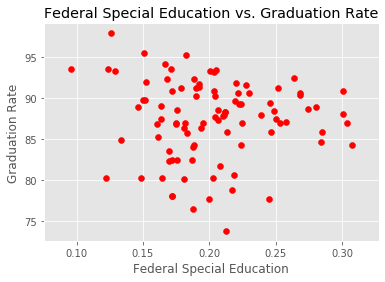

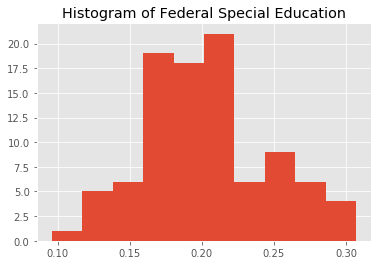

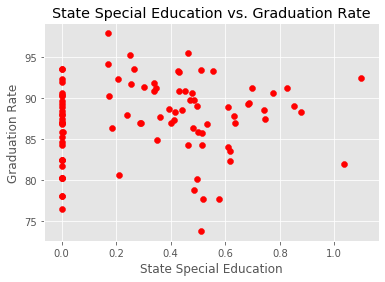

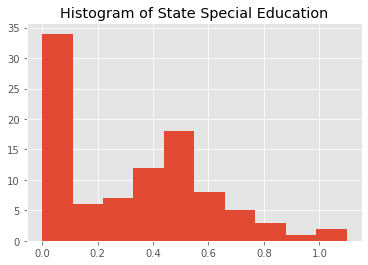

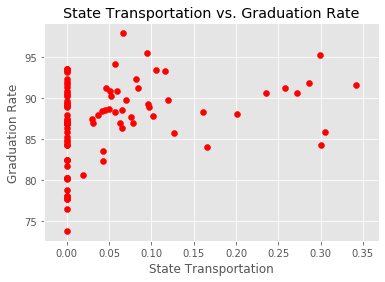

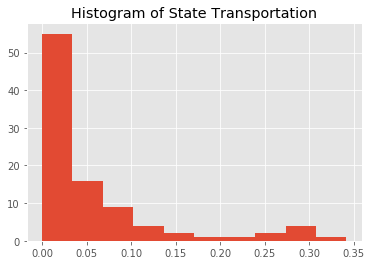

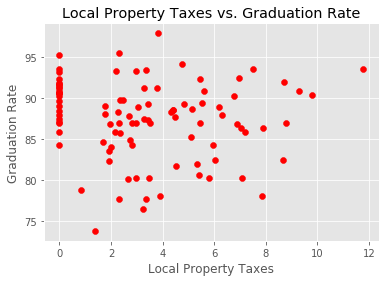

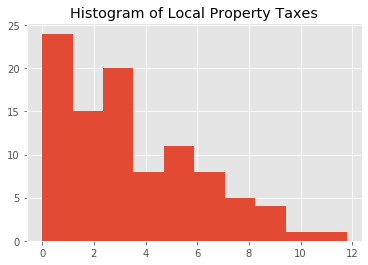

In [241]:
features_rev = ['Federal Child Nutrition','Federal Special Education','State Special Education',
               'State Transportation','Local Property Taxes']

b = outliers_rem(features_rev, tot_rev_with_grad)

EDA(b,tot_rev_with_grad)

The graphs above exhit the histograms of some revenue streams and their scatter plot with high school gradiation rates. The federal child nutrition funds and special education funds appear to have a linear relationship with high school graduation rate whereas the othe three features do not. In addition, child nutrition funds and special education funds are normally distributed.

Similar to the procedure above, we ran linear regression on all the features and selected the most revelant ones based on p-values. And then we ran linear regression on the selected features only. 

In [36]:
tot_rev_with_grad_train = tot_rev_with_grad.reset_index().drop(["index"],axis=1).iloc[train_ind,:]
                                                              
tot_rev_with_grad_train_resp = tot_rev_with_grad_train["grad_rate"]
tot_rev_with_grad_train_predictors = tot_rev_with_grad_train[['Federal Child Nutrition','Federal Special Education','State Special Education',
               'State Transportation','Local Property Taxes']]


results_tot_rev = sm.OLS(tot_rev_with_grad_train_resp, tot_rev_with_grad_train_predictors).fit()

print(results_tot_rev.summary())

                                 OLS Regression Results                                
Dep. Variable:              grad_rate   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              256.5
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    7.82e-45
Time:                        22:14:25   Log-Likelihood:                         -345.35
No. Observations:                  78   AIC:                                      700.7
Df Residuals:                      73   BIC:                                      712.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [40]:
tot_rev_with_grad_train = tot_rev_with_grad.reset_index().drop(["index"],axis=1).iloc[train_ind,:]
                                                              
tot_rev_with_grad_train_resp = tot_rev_with_grad_train["grad_rate"]
tot_rev_with_grad_train_predictors = tot_rev_with_grad_train[['Federal Child Nutrition','Federal Special Education','State Special Education',
               'State Transportation','Local Property Taxes']]


results_tot_rev = sm.OLS(tot_rev_with_grad_train_resp, tot_rev_with_grad_train_predictors).fit()

print(results_tot_rev.summary())

                                 OLS Regression Results                                
Dep. Variable:              grad_rate   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              256.5
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    7.82e-45
Time:                        22:15:55   Log-Likelihood:                         -345.35
No. Observations:                  78   AIC:                                      700.7
Df Residuals:                      73   BIC:                                      712.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

                                 OLS Regression Results                                
Dep. Variable:              grad_rate   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              421.6
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    7.66e-47
Time:                        22:16:04   Log-Likelihood:                         -346.87
No. Observations:                  78   AIC:                                      699.7
Df Residuals:                      75   BIC:                                      706.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

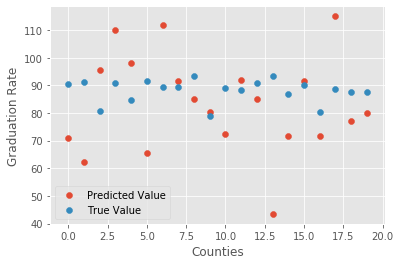

In [41]:
tot_rev_with_grad_train_predictors_mod = tot_rev_with_grad_train[['Federal Special Education',
                                                         'State Special Education','Local Property Taxes']]
results_tot_rev_with_grad_mod = sm.OLS(tot_rev_with_grad_train_resp, tot_rev_with_grad_train_predictors_mod).fit()

print(results_tot_rev_with_grad_mod.summary())


tot_rev_with_grad_test = tot_rev_with_grad.reset_index().drop(["index"],axis=1).iloc[test_ind,:]
k_tot_rev = results_tot_rev_with_grad_mod.predict(tot_rev_with_grad_test[['Federal Special Education','State Special Education','Local Property Taxes']])

plt.scatter(range(int(0),int(len(k))),k_tot_rev)
plt.scatter(range(int(0),int(len(k))),tot_rev_with_grad_test["grad_rate"])
plt.legend(["Predicted Value","True Value"])
plt.xlabel("Counties")
plt.ylabel("Graduation Rate")
plt.show()

Although the scatter plot shows some overlap, the majority of the predictions are still extremely inaccurate. We suspected that maybe more features should be selected to predict the graduation rate and that better methods should be employed for feature selection. The remaining section of the report will investigate these to aspects.

## Investigating Graduation Rates by Demographic

Another aspect of education that we wanted to look at is demographic because we thought that it would be another indicator of how students perform. Ethinic minorities, disabilities, limited English, and economic disadvantage have all been correlated to lower graduation rates, and although we did not ultimatley include this data in our model, we wanted to explore it to incorporate it as a feature.

In [243]:
grad= pd.read_csv("grad_rates_by_race.csv", sep="\t", lineterminator="\r")

In [244]:
import re

selected_cols = ['State']
for i in range(10,len(grad.columns)):
#     print(grad[grad.columns[i]].isna().sum())
    if grad[grad.columns[i]].isna().sum() != 77: selected_cols += [grad.columns[i]]
# grad_parsed = grad[selected_cols]

selected_rows = []
for i in range(len(grad)-13):
#     print(grad[i:i+1].isna().sum().sum())
    if (grad[i:i+1].isna().sum().sum() != 25): selected_rows += [i]

grad_parsed = grad[selected_cols].iloc[selected_rows].reset_index()
grad_parsed = grad_parsed.drop('index', axis=1).drop([3], axis=0)

header = ["State","Total", "White", "Black", "Hispanic", "Asian/Pacific Islander", "Asian", "Pacific Islander", 
          "American Indian/Alaska/Native", "Two or more races", "Students with Disabilities", 
          "Limited English", "Economically disadvantaged"]

grad_parsed.columns = header
grad_parsed = grad_parsed[3:].reset_index().drop('index', axis=1)

states=[]
for i in grad_parsed['State']:
    states += [re.sub("[^a-zA-Z]+", "", i)]
grad_parsed["State"] = states

grad_parsed.to_csv('grad_rates_by_race_parsed.csv', index=False)

In [9]:
agcr = pd.read_csv('grad_rates_by_race_parsed.csv')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], <a list of 11 Text xticklabel objects>)

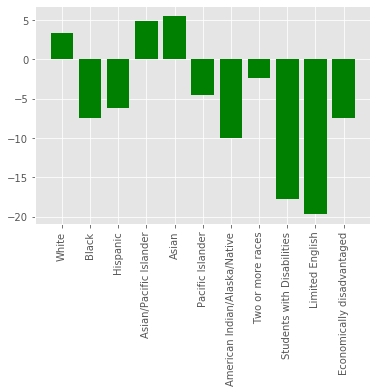

In [59]:
means_by_dem = dict()
for col in range(2,len(agcr.columns)):
    ok = []
    for row in range(len(agcr)):
        if type(agcr.iloc[row,col]) == np.int64 or agcr.iloc[row,col].isdigit(): 
            ok += [int(agcr.iloc[row,col]) - agcr.iloc[row,1]]
    means_by_dem[agcr.columns[col]] = np.mean(ok)

# Average difference in percentage between racial demographic and total
means_by_dem

plt.bar(means_by_dem.keys(), means_by_dem.values(), color='g')
plt.xticks(rotation=90)

The visualization above shows how the graduation rates for various groups differs from the national average. We can see that White and Asian students tend to have graduation rates higher than the national average, while all other races and gropus have graduation rates lower than the national average. Additionally, students with disabilities and limited English students have much lower graduation rates that are close to 20% lower than the national average, which is likely because there is limited support and resources in public schools for these students. If we were to see an increase in expenditure in the Pupil Support category over time, that may make the gap between these two groups and the national average smaller.

# Enrollment and Pupil Teacher Ratio

Looking into some other features, we wanted to incorporate pupil/teacher ratio and enrollment into our model. Pupil/teacher ratio can be important especially in the top 100 schools that we based our study on because of the importance of smaller class sizes and individualized student attention, particularly in early education. We hypothesiszed that it would have an effect on the model because students may be more likely to graduate if they were in a school system where they felt their teachers had time and attention to give them.

In [2]:
##Read table using pandas 
df1 = pd.read_csv("enrollment_gender_race.csv",skiprows=6)
df1_n = df1[:-5]
# df1_n

In [3]:
ratio = pd.DataFrame([],columns = ['County Name', 'State', 'Pupil/Teacher Ratio'])
counties, states, ratios = [],[], []
for i in range(len(df1_n)):
    if df1_n['Pupil/Teacher Ratio [Public School] 2016-17'][i] != '†':
        counties += [df1_n['County Name'][i][:-5]]
        states += [df1_n['County Name'][i][-4:].strip()]
        ratios += [float(df1_n['Pupil/Teacher Ratio [Public School] 2016-17'][i])]
ratio['County Name'] = counties
ratio['State'] = states
ratio['Pupil/Teacher Ratio'] = ratios
# ratio

In [4]:
df2 = pd.read_csv('graduation_rates_total.csv')
counties, states, vals = [], [], []
state_abbv = pd.read_csv('state_to_abbreviation.csv', names=['State','Abbv'])
state_abbv_dict = {}
for i in range(len(state_abbv)):
    state_abbv_dict[state_abbv['State'][i]] = state_abbv['Abbv'][i]
for i in range(len(df2)):
    name = df2['name'][i].split(',')
    if name[1].strip() in state_abbv_dict.keys():
        counties += [name[0]]
        states += [state_abbv_dict[name[1].strip()]]
        vals += [df2['value'][i]]

grad_rates_c = pd.DataFrame([],columns = ['County Name', 'State', 'Graduation Rate'])
grad_rates_c['County Name'] = counties
grad_rates_c['State'] = states
grad_rates_c['Graduation Rate'] = vals
# grad_rates_c

In [5]:
grad_rates_c_new = pd.DataFrame([])
temp = []
for i in range(1,len(grad_rates_c)):
    if grad_rates_c['County Name'][i] == grad_rates_c['County Name'][i-1]:
        # Add to temp list
        temp += [grad_rates_c['Graduation Rate'][i-1]]
    else:
        # Put into grad_rates_c_new
        temp += [grad_rates_c['Graduation Rate'][i-1]]
        mean = np.mean(temp)
        grad_rates_c_new = grad_rates_c_new.append([[grad_rates_c['County Name'][i-1], 
                                                    grad_rates_c['State'][i-1], mean]])
        temp = []
        
grad_rates_c_new.columns = ['County Name', 'State', 'Grad Rate']
# grad_rates_c_new

In [6]:
merged = ratio.merge(grad_rates_c_new, on=['County Name', 'State'], how='inner')

# merged.to_csv('pupil_ratio_grad_by_county.csv')

In [7]:
revenue = pd.read_csv('revenue.csv')
expenditure = pd.read_csv('per_pupil_exp.csv')
teacher_ratio_grad = pd.read_csv('pupil_ratio_grad_by_county.csv')

In [8]:
states = []
for i in range(len(revenue)):
    states += [state_abbv_dict[revenue['State'][i].strip()]]
revenue['State'] = states
expenditure['State'] = states

In [9]:
money = pd.concat([revenue.iloc[:,4:], expenditure], axis=1)
money = money[['School System', 'State', 'Enrollment',
       'Federal Title I', 
       'State General Formula Assistance', 
       'Local Taxes Parent Government Contributions',
       'Charges', 'Instruction_Salaries',
       'Instruction_EmployeeBenefits', 'Support_Pupil',
       'Support_Staff', 'Support_GeneralAdmin', 'Support_SchoolAdmin']]

In [23]:
full_df = money.merge(merged, left_on=["School System","State"], right_on=["County Name","State"])
full_df = pd.concat([full_df.iloc[:,2:-3],full_df.iloc[:,-1]], axis=1)

# Feature Selection

From the datasets with revenue, expenditure, and pupil/teacher ratio, enrollment, and graduation rate, we wanted to select the features that best predicted the graduation rate, the response variable. To do this we used sklearn's SelectKBest function (we used k=5) to find the top 5 features that were correlated with graduation rate. This helped us eliminate variables that were either not correlated or did not significantly explain the variance in graduation rate so we could build a more accurate model. We found that Instruction Salares, Instruction Employee Benefits, Pupil Support, Staff Support, and School Admin Support were the top 5 features. This is interesting because it suggests that spending money on these categories could lead to higher graduation rates. Although there are other factors that affect graduation rate, in terms of where money is spent, these areas appear to be the most influential. In future work, we would further test the hypothesis that of all the categories that public funds are spent in school systems, Instructor Salaries and Benefits as well as In-School Support is key to successful public schools.

In [12]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif

X = full_df.iloc[:, :-1]
y = full_df.iloc[:,-1]

X_new = SelectKBest(f_classif, k=5).fit_transform(X, y)
pd.DataFrame(X_new)

0       1       2       3       4
0   10413.0  6584.0   129.0   102.0   574.0
1    4466.0  2296.0   729.0   987.0   978.0
2    4562.0  2235.0   608.0   627.0   697.0
3    3094.0  1119.0   386.0   432.0   460.0
4    3073.0   882.0   479.0   427.0   504.0
5    3663.0   610.0   374.0   435.0   614.0
6    4230.0   801.0   427.0   458.0   451.0
7    3424.0  1202.0   307.0   593.0   546.0
8    6037.0  2606.0   853.0   995.0   858.0
9    5262.0  2314.0  1348.0   483.0  1028.0
10   3921.0  1471.0   434.0   364.0   752.0
11   4105.0  1368.0   515.0   282.0   485.0
12   4398.0   683.0   553.0   677.0   596.0
13   4078.0   641.0   520.0   547.0   525.0
14   3607.0  2505.0   454.0   493.0   493.0
15   5935.0  2561.0   777.0   572.0   952.0
16   4200.0  2250.0  1007.0   543.0   753.0
17   4317.0   630.0   395.0   318.0   397.0
18   4719.0   751.0   488.0   349.0   484.0
19   4596.0   730.0   537.0   548.0   655.0
20   4767.0   816.0   527.0   416.0   645.0
21   4448.0  1713.0   453.0   415.0   643.0
22   5436.0  2478.0   753.0   623.0  1027.0
23   5601.0  2684.0   792.0   671.0  1076.0
24   3716.0  1109.0   400.0   567.0   553.0
25   4207.0   695.0   651.0  1159.0  1204.0
26   3900.0  1363.0   920.0   240.0   538.0
27   4455.0  1495.0   542.0   822.0   769.0
28   4451.0   694.0   673.0   631.0   545.0
29   4121.0   820.0   501.0   538.0   534.0
..      ...     ...     ...     ...     ...
39   4222.0  2082.0   747.0   751.0   732.0
40   4008.0  1359.0   593.0   383.0   527.0
41   2694.0  1327.0   219.0   285.0   472.0
42   3119.0  1012.0   408.0   521.0   544.0
43   2873.0  1416.0   310.0   234.0   458.0
44   2474.0  1090.0   224.0   264.0   409.0
45   3507.0  1429.0   809.0   597.0   602.0
46   3005.0   904.0   674.0   463.0   388.0
47   4362.0  2083.0   683.0   573.0   683.0
48   3332.0   947.0   361.0   569.0   572.0
49   3825.0  1688.0   847.0  2001.0   756.0
50   4045.0  1914.0   426.0   526.0   581.0
51   4211.0   782.0   607.0   719.0   632.0
52   3222.0  1282.0   539.0   424.0   528.0
53   4365.0   646.0   411.0   388.0   507.0
54   4878.0   670.0   518.0   388.0   489.0
55   4107.0  1410.0   571.0   304.0   492.0
56   5169.0  1400.0   579.0   390.0   492.0
57   5688.0  1929.0  1000.0   770.0   884.0
58   4513.0   709.0   475.0   353.0   561.0
59   4738.0  1621.0   730.0   431.0   784.0
60   4324.0  1927.0   883.0   640.0   926.0
61   4200.0  1056.0   675.0   789.0   633.0
62   4032.0  1523.0   467.0   622.0   602.0
63   4059.0  1620.0   987.0   599.0   699.0
64   3583.0  1821.0   413.0  1266.0   912.0
65   3747.0  1868.0   508.0   929.0   834.0
66   2828.0   840.0   370.0   470.0   501.0
67   3703.0  1837.0   790.0   390.0   755.0
68   3781.0  1374.0   756.0   776.0   768.0

[69 rows x 5 columns]

# Linear Regression Model

Finally, we ran a linear regression on the model with the top 5 features selected above and Graduation Rate as the response variable. This model has a very high test error because the sample set is very small (only 69 of the top 100 school systems were tested because of a lack of county information for features other than revenue and expenditure) and because graduation rate might not be the best success metric since it may not be correlated with the explanatory variables. To improve this model, we would create a success metric from standardized test scores and college acceptances in addition to just graduation rate, and we would look at the revenue and expenditure for the top 100 school systems over the course of many years and not at just one fiscal year.

In [18]:
from sklearn import metrics
reg = linear_model.LinearRegression().fit(X_new[:53], y[:53])
y_test = reg.predict(X_new[53:])
metrics.mean_squared_error(y[53:],y_test)

23.764648682390884

# Standardized Test Scores versus Graduation Rates

Another aspect we wanted to look at was Standardized test scores on graduation rates. The standardized test scores data is broken up into 4 different catagories: math, science, reading, and writing. This data takes all the various tests that are done by states, and normalizes it together to weight all states test averages fairly. We assumed that all students would have to be at least average in every category in order to fair well in school, and hence graduate. Out of all of the different categories within the standardized tests, our initial hypothesis was that the states with the higher scores in the math section results be the ones with the highest graduation rates as math is highly emphasized within various school districts around the united states. Looking at the initial data given also, math was seen to have the highest scores in comparison to the other categories. After our initial analysis, we took the normalized standardized test scores per states and merged it with the graduation rates per state in order to continue our analysis. We then used selectKbest to figure out which category had the most impact on graduation rates. After further analysis we found that reading was seen to have the most impact on graduation rates, followed by writing, science, and then math. This very much contradicted our initial assumptions as math ended up being the least impactful on graduation rates. Given these results, the fact that reading and writing were both higher than science and math, it would indicate that states would most likely have higher graduation rates than they currently have if they focused more on the English department within each school. This would mean allocating more money into English department to provide the teachers with better instruction material and/or hired better English teachers. 

In [6]:
national_math_1 = pd.read_csv("National_math_2017.csv",encoding='latin-1', na_values = 0)
national_reading_1 = pd.read_csv("National_reading_2017.csv",encoding='latin-1', na_values = 0)
national_science_1 = pd.read_csv("National_science_2017.csv",encoding='latin-1', na_values = 0)
national_writing_1 = pd.read_csv("National_writing_2017.csv",encoding='latin-1', na_values = 0) 

In [7]:
national_math = national_math_1.rename({'MN':"Math"}, axis='columns')
national_reading = national_reading_1.rename({'MN':"Reading"}, axis='columns')
national_science = national_science_1.rename({'MN':"Science"}, axis='columns')
national_writing = national_writing_1.rename({'MN':"Writing"}, axis='columns')

In [10]:
national = national_math.merge(national_reading,on='Jurisdiction').merge(national_science,on='Jurisdiction').merge(national_writing,on='Jurisdiction')
national = national[['Jurisdiction', 'Math', 'Science', 'Writing', 'Reading']]





print(type(national))
standard = national.loc[national['Jurisdiction'] == 'National public']

national['Jurisdiction'] = national['Jurisdiction'].str.replace(" ","")
print(national)
std_math = list(dict(standard['Math']).values())[0]
std_sci = list(dict(standard['Science']).values())[0]
std_wri = list(dict(standard['Writing']).values())[0]
std_read = list(dict(standard['Reading']).values())[0]




values = {'Math': std_math, 'Science': std_sci, 'Writing': std_wri, 
          'Reading': std_read}

cash = national.fillna(value=values)
cash['average'] = cash.mean(numeric_only=True, axis=1)


agcr = agcr.rename({'State': 'Jurisdiction'}, axis='columns')
agcr_cond = agcr[['Jurisdiction', 'Total']]
agcr_cond = agcr_cond.rename({'Total':"Grad Rate"}, axis='columns')
cash = cash.merge(agcr_cond,on= "Jurisdiction")

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif

print(cash)
X_new = SelectKBest(f_classif, k=1).fit_transform(cash.iloc[:,1:-1], cash.iloc[:,-1])
pd.DataFrame(X_new)




    
    

<class 'pandas.core.frame.DataFrame'>
          Jurisdiction  Math  Science  Writing  Reading
0        Massachusetts   297    162.0    167.0    278.0
1            Minnesota   294    162.0    156.0    269.0
2         NewHampshire   293    165.0    160.0    275.0
3                DoDEA   293    166.0    165.0    280.0
4            NewJersey   292    156.0    175.0    275.0
5             Virginia   290    160.0    157.0    268.0
6           Washington   289    157.0    158.0    272.0
7              Wyoming   289    160.0    158.0    269.0
8             Nebraska   288    160.0      NaN    269.0
9          NorthDakota   288    161.0    154.0    265.0
10           Wisconsin   288    159.0    158.0    269.0
11                Ohio   288    157.0    156.0    268.0
12             Indiana   288    156.0    155.0    272.0
13             Vermont   288    163.0    162.0    273.0
14                Utah   287    166.0    152.0    269.0
15        Pennsylvania   286      NaN    159.0    270.0
16        

0
0   278.0
1   269.0
2   275.0
3   275.0
4   268.0
5   272.0
6   269.0
7   269.0
8   265.0
9   269.0
10  268.0
11  272.0
12  273.0
13  269.0
14  270.0
15  267.0
16  270.0
17  268.0
18  267.0
19  267.0
20  270.0
21  273.0
22  269.0
23  260.0
24  263.0
25  266.0
26  263.0
27  264.0
28  267.0
29  266.0
30  267.0
31  266.0
32  265.0
33  267.0
34  262.0
35  263.0
36  265.0
37  261.0
38  266.0
39  258.0
40  263.0
41  260.0
42  261.0
43  260.0
44  260.0
45  259.0
46  256.0
47  256.0
48  258.0
49  257.0
50  247.0

# Conclusions and Further Investigation

We have started the data cleaning, exploratory data analysis, and the preliminary models for this study, and we have created cleaner datasets to work with as well as some guidance for the data analysis and some preliminary linear regression models predicting graduation rate from public school revenue and expenditure. We determined that the school expenditure values were the most important features in our data to predict graduation rate, and it is worth pursuing a further breakdown of the expenditure as well as using data for multiple years as opposed to from one fiscal year. Additionally, increasing the sample size by finding financial information for more than 100 school systems would improve the accuracy of the model.

In terms of other features to look into, we want to create a metric or "success score" that incorporates standardized test scores and college acceptance statistics in addition to graduation rate to measure public school success. We would then test this metric against various explantory variables including but not limited to the ones used in this study (revenue, expenditure, enrollment, pupil/teacher ratio) and use that to classify schools into various success levels. Ultimately, we want to use this model to determine the best distribution of revenue and expenditure and test other features that affect how students fare in public schools. This study would provide data-driven evidence for how much money and for what purposes the federal, state, and local governments should allocate money for, as well as how schools should spend the money they receive on faculty, staff, and students.

# Sources

1. https://www.cbpp.org/research/state-budget-and-tax/a-punishing-decade-for-school-funding
2. https://www.census.gov/programs-surveys/school-finances.html
3. https://nces.ed.gov/ccd/elsi/tableGenerator.aspx?savedTableID=126808
4. https://nces.ed.gov/programs/digest/d18/tables/dt18_219.46.asp
